# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact mlta-2022-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [ ]:
!nvidia-smi

Tue May 17 16:09:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

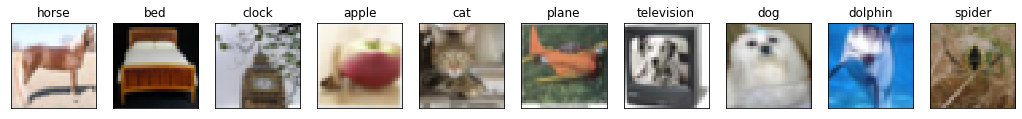

In [ ]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

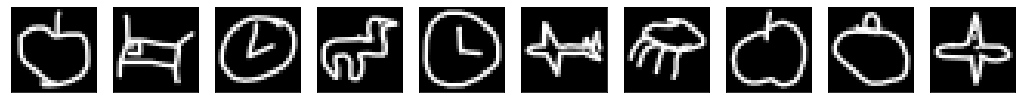

In [ ]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


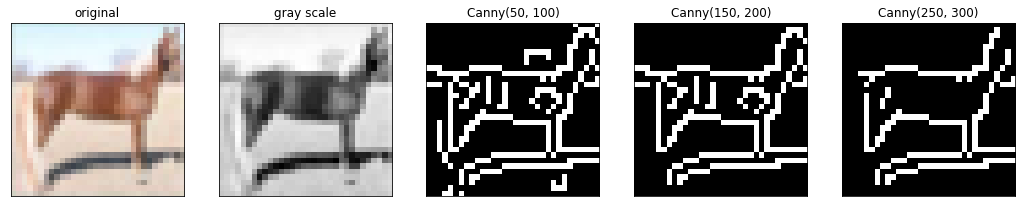

In [ ]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [ ]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [15]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding = 1),
            models.resnet50(),
            nn.Linear(1000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
        )

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, stride=1, padding = 1),
            models.convnext_base(),
            nn.Linear(1000, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
        )
        self.linear = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
        )
    def forward(self, x):
        x = self.linear(torch.cat((self.conv0(x), self.conv1(x)), 1))
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [17]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
optimizer_F = optim.AdamW(feature_extractor.parameters(), lr=lr)
optimizer_C = optim.AdamW(label_predictor.parameters(), lr=lr)
optimizer_D = optim.AdamW(domain_classifier.parameters(), lr=lr)

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [18]:
num_epoch = 500
def lamb_scheduler(epoch, tot_epoch=num_epoch, mx=2.5):
    return mx/(1+ math.exp(-10*((epoch+1)/tot_epoch))) - 1

In [19]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0
    
    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

from tqdm import tqdm
for epoch in tqdm(range(num_epoch)):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=lamb_scheduler(epoch, num_epoch))

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')
    if epoch % 100 == 0:
      torch.save(feature_extractor.state_dict(), f'extractor_model_{epoch}.bin')
      torch.save(label_predictor.state_dict(), f'predictor_model_{epoch}.bin')
    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:34<4:46:01, 34.39s/it]

epoch   0: train D loss: 0.6935, train F loss: 2.1030, acc 0.1322


  0%|          | 2/500 [01:08<4:42:28, 34.03s/it]

epoch   1: train D loss: 0.6793, train F loss: 1.9952, acc 0.1706


  1%|          | 3/500 [01:41<4:37:40, 33.52s/it]

epoch   2: train D loss: 0.6351, train F loss: 1.9273, acc 0.1806


  1%|          | 4/500 [02:14<4:35:56, 33.38s/it]

epoch   3: train D loss: 0.6529, train F loss: 1.8865, acc 0.1940


  1%|          | 5/500 [02:47<4:33:51, 33.20s/it]

epoch   4: train D loss: 0.6464, train F loss: 1.8596, acc 0.2008


  1%|          | 6/500 [03:19<4:32:17, 33.07s/it]

epoch   5: train D loss: 0.6553, train F loss: 1.8328, acc 0.2052


  1%|▏         | 7/500 [03:53<4:31:41, 33.07s/it]

epoch   6: train D loss: 0.6822, train F loss: 1.8014, acc 0.2106


  2%|▏         | 8/500 [04:25<4:30:52, 33.03s/it]

epoch   7: train D loss: 0.6602, train F loss: 1.7637, acc 0.2204


  2%|▏         | 9/500 [04:59<4:30:20, 33.04s/it]

epoch   8: train D loss: 0.6734, train F loss: 1.7204, acc 0.2434


  2%|▏         | 10/500 [05:32<4:29:46, 33.03s/it]

epoch   9: train D loss: 0.6828, train F loss: 1.7027, acc 0.2386


  2%|▏         | 11/500 [06:05<4:29:58, 33.13s/it]

epoch  10: train D loss: 0.6858, train F loss: 1.6614, acc 0.2512


  2%|▏         | 12/500 [06:39<4:31:58, 33.44s/it]

epoch  11: train D loss: 0.6810, train F loss: 1.6463, acc 0.2420


  3%|▎         | 13/500 [07:12<4:30:14, 33.29s/it]

epoch  12: train D loss: 0.6907, train F loss: 1.6004, acc 0.2660


  3%|▎         | 14/500 [07:45<4:28:53, 33.20s/it]

epoch  13: train D loss: 0.6831, train F loss: 1.5954, acc 0.2662


  3%|▎         | 15/500 [08:18<4:28:34, 33.23s/it]

epoch  14: train D loss: 0.6754, train F loss: 1.5780, acc 0.2756


  3%|▎         | 16/500 [08:51<4:26:59, 33.10s/it]

epoch  15: train D loss: 0.6879, train F loss: 1.5562, acc 0.2764


  3%|▎         | 17/500 [09:24<4:26:11, 33.07s/it]

epoch  16: train D loss: 0.6834, train F loss: 1.5390, acc 0.2874


  4%|▎         | 18/500 [09:57<4:25:40, 33.07s/it]

epoch  17: train D loss: 0.6844, train F loss: 1.5426, acc 0.2890


  4%|▍         | 19/500 [10:30<4:24:48, 33.03s/it]

epoch  18: train D loss: 0.6819, train F loss: 1.5404, acc 0.2810


  4%|▍         | 20/500 [11:03<4:23:59, 33.00s/it]

epoch  19: train D loss: 0.6876, train F loss: 1.4931, acc 0.2982


  4%|▍         | 21/500 [11:36<4:23:14, 32.97s/it]

epoch  20: train D loss: 0.6921, train F loss: 1.4510, acc 0.3078


  4%|▍         | 22/500 [12:09<4:23:47, 33.11s/it]

epoch  21: train D loss: 0.6866, train F loss: 1.4457, acc 0.3116


  5%|▍         | 23/500 [12:43<4:24:59, 33.33s/it]

epoch  22: train D loss: 0.6872, train F loss: 1.4127, acc 0.3180


  5%|▍         | 24/500 [13:18<4:27:04, 33.66s/it]

epoch  23: train D loss: 0.6904, train F loss: 1.4116, acc 0.3264


  5%|▌         | 25/500 [13:52<4:28:09, 33.87s/it]

epoch  24: train D loss: 0.6764, train F loss: 1.4117, acc 0.3270


  5%|▌         | 26/500 [14:29<4:36:12, 34.96s/it]

epoch  25: train D loss: 0.6763, train F loss: 1.4671, acc 0.2936


  5%|▌         | 27/500 [15:07<4:42:00, 35.77s/it]

epoch  26: train D loss: 0.6867, train F loss: 1.4365, acc 0.3120


  6%|▌         | 28/500 [15:45<4:45:51, 36.34s/it]

epoch  27: train D loss: 0.6854, train F loss: 1.4019, acc 0.3174


  6%|▌         | 29/500 [16:22<4:48:00, 36.69s/it]

epoch  28: train D loss: 0.6836, train F loss: 1.3735, acc 0.3344


  6%|▌         | 30/500 [17:00<4:49:04, 36.90s/it]

epoch  29: train D loss: 0.6890, train F loss: 1.3095, acc 0.3596


  6%|▌         | 31/500 [17:34<4:43:15, 36.24s/it]

epoch  30: train D loss: 0.6736, train F loss: 1.4615, acc 0.2956


  6%|▋         | 32/500 [18:08<4:36:30, 35.45s/it]

epoch  31: train D loss: 0.6763, train F loss: 1.3701, acc 0.3294


  7%|▋         | 33/500 [18:41<4:30:40, 34.78s/it]

epoch  32: train D loss: 0.6889, train F loss: 1.3095, acc 0.3490


  7%|▋         | 34/500 [19:16<4:30:29, 34.83s/it]

epoch  33: train D loss: 0.6801, train F loss: 1.2981, acc 0.3668


  7%|▋         | 35/500 [19:52<4:31:18, 35.01s/it]

epoch  34: train D loss: 0.6782, train F loss: 1.2749, acc 0.3652


  7%|▋         | 36/500 [20:27<4:31:41, 35.13s/it]

epoch  35: train D loss: 0.6871, train F loss: 1.2275, acc 0.3850


  7%|▋         | 37/500 [21:03<4:32:01, 35.25s/it]

epoch  36: train D loss: 0.6845, train F loss: 1.2150, acc 0.3808


  8%|▊         | 38/500 [21:37<4:30:41, 35.15s/it]

epoch  37: train D loss: 0.6803, train F loss: 1.2039, acc 0.3972


  8%|▊         | 39/500 [22:14<4:34:01, 35.67s/it]

epoch  38: train D loss: 0.6852, train F loss: 1.1841, acc 0.3902


  8%|▊         | 40/500 [22:50<4:33:28, 35.67s/it]

epoch  39: train D loss: 0.6832, train F loss: 1.1653, acc 0.4034


  8%|▊         | 41/500 [23:27<4:35:32, 36.02s/it]

epoch  40: train D loss: 0.6804, train F loss: 1.1467, acc 0.4018


  8%|▊         | 42/500 [24:04<4:37:16, 36.32s/it]

epoch  41: train D loss: 0.6893, train F loss: 1.1444, acc 0.3962


  9%|▊         | 43/500 [24:39<4:33:24, 35.90s/it]

epoch  42: train D loss: 0.6792, train F loss: 1.1512, acc 0.4098


  9%|▉         | 44/500 [25:13<4:28:05, 35.28s/it]

epoch  43: train D loss: 0.6810, train F loss: 1.1833, acc 0.3794


  9%|▉         | 45/500 [25:47<4:24:21, 34.86s/it]

epoch  44: train D loss: 0.6794, train F loss: 1.3034, acc 0.3402


  9%|▉         | 46/500 [26:20<4:21:33, 34.57s/it]

epoch  45: train D loss: 0.6872, train F loss: 1.1622, acc 0.3920


  9%|▉         | 47/500 [26:55<4:20:20, 34.48s/it]

epoch  46: train D loss: 0.6856, train F loss: 1.1024, acc 0.4090


 10%|▉         | 48/500 [27:29<4:18:45, 34.35s/it]

epoch  47: train D loss: 0.6768, train F loss: 1.0737, acc 0.4154


 10%|▉         | 49/500 [28:03<4:17:25, 34.25s/it]

epoch  48: train D loss: 0.6884, train F loss: 1.0220, acc 0.4358


 10%|█         | 50/500 [28:37<4:16:18, 34.17s/it]

epoch  49: train D loss: 0.6902, train F loss: 0.9984, acc 0.4448


 10%|█         | 51/500 [29:11<4:15:37, 34.16s/it]

epoch  50: train D loss: 0.6872, train F loss: 0.9557, acc 0.4508


 10%|█         | 52/500 [29:45<4:15:05, 34.16s/it]

epoch  51: train D loss: 0.6848, train F loss: 0.9546, acc 0.4556


 11%|█         | 53/500 [30:19<4:14:30, 34.16s/it]

epoch  52: train D loss: 0.6862, train F loss: 0.9428, acc 0.4564


 11%|█         | 54/500 [30:54<4:14:27, 34.23s/it]

epoch  53: train D loss: 0.6897, train F loss: 0.9062, acc 0.4632


 11%|█         | 55/500 [31:28<4:13:30, 34.18s/it]

epoch  54: train D loss: 0.6892, train F loss: 0.8744, acc 0.4740


 11%|█         | 56/500 [32:02<4:12:43, 34.15s/it]

epoch  55: train D loss: 0.6895, train F loss: 0.8682, acc 0.4838


 11%|█▏        | 57/500 [32:36<4:12:32, 34.21s/it]

epoch  56: train D loss: 0.6812, train F loss: 0.8449, acc 0.4890


 12%|█▏        | 58/500 [33:10<4:11:45, 34.18s/it]

epoch  57: train D loss: 0.6851, train F loss: 0.8561, acc 0.4710


 12%|█▏        | 59/500 [33:44<4:10:58, 34.15s/it]

epoch  58: train D loss: 0.6913, train F loss: 0.8228, acc 0.4840


 12%|█▏        | 60/500 [34:18<4:09:31, 34.03s/it]

epoch  59: train D loss: 0.6807, train F loss: 0.8122, acc 0.4920


 12%|█▏        | 61/500 [34:52<4:08:50, 34.01s/it]

epoch  60: train D loss: 0.6918, train F loss: 0.7665, acc 0.4968


 12%|█▏        | 62/500 [35:26<4:08:08, 33.99s/it]

epoch  61: train D loss: 0.6911, train F loss: 0.7368, acc 0.5030


 13%|█▎        | 63/500 [36:00<4:07:17, 33.95s/it]

epoch  62: train D loss: 0.6869, train F loss: 0.7276, acc 0.5108


 13%|█▎        | 64/500 [36:34<4:06:29, 33.92s/it]

epoch  63: train D loss: 0.6882, train F loss: 0.6927, acc 0.5126


 13%|█▎        | 65/500 [37:08<4:06:27, 33.99s/it]

epoch  64: train D loss: 0.6936, train F loss: 0.6816, acc 0.5208


 13%|█▎        | 66/500 [37:42<4:06:28, 34.07s/it]

epoch  65: train D loss: 0.6908, train F loss: 0.6781, acc 0.5160


 13%|█▎        | 67/500 [38:16<4:05:57, 34.08s/it]

epoch  66: train D loss: 0.6874, train F loss: 0.6808, acc 0.5244


 14%|█▎        | 68/500 [38:51<4:07:35, 34.39s/it]

epoch  67: train D loss: 0.6933, train F loss: 0.6620, acc 0.5190


 14%|█▍        | 69/500 [39:28<4:12:23, 35.14s/it]

epoch  68: train D loss: 0.6910, train F loss: 0.6360, acc 0.5314


 14%|█▍        | 70/500 [40:08<4:22:50, 36.68s/it]

epoch  69: train D loss: 0.6901, train F loss: 0.6221, acc 0.5366


 14%|█▍        | 71/500 [40:43<4:17:56, 36.08s/it]

epoch  70: train D loss: 0.6913, train F loss: 0.6195, acc 0.5348


 14%|█▍        | 72/500 [41:17<4:13:28, 35.53s/it]

epoch  71: train D loss: 0.6910, train F loss: 0.6111, acc 0.5492


 15%|█▍        | 73/500 [41:52<4:10:22, 35.18s/it]

epoch  72: train D loss: 0.6900, train F loss: 0.6094, acc 0.5342


 15%|█▍        | 74/500 [42:26<4:07:59, 34.93s/it]

epoch  73: train D loss: 0.6886, train F loss: 0.5512, acc 0.5572


 15%|█▌        | 75/500 [43:00<4:05:37, 34.68s/it]

epoch  74: train D loss: 0.6910, train F loss: 0.5389, acc 0.5576


 15%|█▌        | 76/500 [43:34<4:02:43, 34.35s/it]

epoch  75: train D loss: 0.6902, train F loss: 0.5219, acc 0.5670


 15%|█▌        | 77/500 [44:08<4:01:34, 34.27s/it]

epoch  76: train D loss: 0.6916, train F loss: 0.4805, acc 0.5722


 16%|█▌        | 78/500 [44:43<4:02:20, 34.46s/it]

epoch  77: train D loss: 0.6900, train F loss: 0.4780, acc 0.5824


 16%|█▌        | 79/500 [45:17<4:01:18, 34.39s/it]

epoch  78: train D loss: 0.6899, train F loss: 0.4470, acc 0.5932


 16%|█▌        | 80/500 [45:51<4:00:14, 34.32s/it]

epoch  79: train D loss: 0.6909, train F loss: 0.4379, acc 0.5824


 16%|█▌        | 81/500 [46:26<4:01:04, 34.52s/it]

epoch  80: train D loss: 0.6912, train F loss: 0.4406, acc 0.5896


 16%|█▋        | 82/500 [47:02<4:02:25, 34.80s/it]

epoch  81: train D loss: 0.6916, train F loss: 0.4517, acc 0.5934


 17%|█▋        | 83/500 [47:37<4:03:41, 35.06s/it]

epoch  82: train D loss: 0.6915, train F loss: 0.4059, acc 0.5980


 17%|█▋        | 84/500 [48:13<4:03:59, 35.19s/it]

epoch  83: train D loss: 0.6906, train F loss: 0.3950, acc 0.6056


 17%|█▋        | 85/500 [48:48<4:03:18, 35.18s/it]

epoch  84: train D loss: 0.6908, train F loss: 0.3690, acc 0.6198


 17%|█▋        | 86/500 [49:23<4:03:19, 35.26s/it]

epoch  85: train D loss: 0.6921, train F loss: 0.3578, acc 0.6224


 17%|█▋        | 87/500 [49:58<4:01:49, 35.13s/it]

epoch  86: train D loss: 0.6918, train F loss: 0.3815, acc 0.6098


 18%|█▊        | 88/500 [50:33<4:01:11, 35.13s/it]

epoch  87: train D loss: 0.6924, train F loss: 0.3328, acc 0.6174


 18%|█▊        | 89/500 [51:08<3:59:46, 35.00s/it]

epoch  88: train D loss: 0.6912, train F loss: 0.3065, acc 0.6326


 18%|█▊        | 90/500 [51:43<3:59:23, 35.03s/it]

epoch  89: train D loss: 0.6878, train F loss: 0.3072, acc 0.6306


 18%|█▊        | 91/500 [52:18<3:58:45, 35.03s/it]

epoch  90: train D loss: 0.6921, train F loss: 0.2722, acc 0.6428


 18%|█▊        | 92/500 [52:53<3:57:07, 34.87s/it]

epoch  91: train D loss: 0.6926, train F loss: 0.2774, acc 0.6410


 19%|█▊        | 93/500 [53:27<3:55:37, 34.74s/it]

epoch  92: train D loss: 0.6911, train F loss: 0.2502, acc 0.6476


 19%|█▉        | 94/500 [54:02<3:54:39, 34.68s/it]

epoch  93: train D loss: 0.6915, train F loss: 0.2503, acc 0.6414


 19%|█▉        | 95/500 [54:36<3:54:15, 34.71s/it]

epoch  94: train D loss: 0.6874, train F loss: 0.2545, acc 0.6438


 19%|█▉        | 96/500 [55:11<3:53:41, 34.71s/it]

epoch  95: train D loss: 0.6926, train F loss: 0.2296, acc 0.6562


 19%|█▉        | 97/500 [55:46<3:53:31, 34.77s/it]

epoch  96: train D loss: 0.6899, train F loss: 0.2228, acc 0.6522


 20%|█▉        | 98/500 [56:21<3:52:51, 34.75s/it]

epoch  97: train D loss: 0.6913, train F loss: 0.1736, acc 0.6644


 20%|█▉        | 99/500 [56:55<3:52:19, 34.76s/it]

epoch  98: train D loss: 0.6903, train F loss: 0.1692, acc 0.6686


 20%|██        | 100/500 [57:30<3:51:00, 34.65s/it]

epoch  99: train D loss: 0.6922, train F loss: 0.1735, acc 0.6600


 20%|██        | 101/500 [58:07<3:55:15, 35.38s/it]

epoch 100: train D loss: 0.6885, train F loss: 0.1447, acc 0.6716


 20%|██        | 102/500 [58:42<3:54:14, 35.31s/it]

epoch 101: train D loss: 0.6913, train F loss: 0.1382, acc 0.6732


 21%|██        | 103/500 [59:17<3:53:40, 35.32s/it]

epoch 102: train D loss: 0.6901, train F loss: 0.1080, acc 0.6842


 21%|██        | 104/500 [59:53<3:54:04, 35.47s/it]

epoch 103: train D loss: 0.6914, train F loss: 0.1069, acc 0.6888


 21%|██        | 105/500 [1:00:28<3:53:08, 35.41s/it]

epoch 104: train D loss: 0.6901, train F loss: 0.0779, acc 0.6970


 21%|██        | 106/500 [1:01:04<3:51:49, 35.30s/it]

epoch 105: train D loss: 0.6902, train F loss: 0.0608, acc 0.6928


 21%|██▏       | 107/500 [1:01:39<3:50:51, 35.25s/it]

epoch 106: train D loss: 0.6899, train F loss: 0.0808, acc 0.6850


 22%|██▏       | 108/500 [1:02:14<3:49:45, 35.17s/it]

epoch 107: train D loss: 0.6895, train F loss: 0.0700, acc 0.6932


 22%|██▏       | 109/500 [1:02:49<3:49:35, 35.23s/it]

epoch 108: train D loss: 0.6907, train F loss: 0.0872, acc 0.6854


 22%|██▏       | 110/500 [1:03:25<3:49:45, 35.35s/it]

epoch 109: train D loss: 0.6911, train F loss: 0.0520, acc 0.6912


 22%|██▏       | 111/500 [1:04:00<3:48:48, 35.29s/it]

epoch 110: train D loss: 0.6891, train F loss: 0.0400, acc 0.6992


 22%|██▏       | 112/500 [1:04:34<3:46:59, 35.10s/it]

epoch 111: train D loss: 0.6903, train F loss: -0.0009, acc 0.7136


 23%|██▎       | 113/500 [1:05:10<3:46:43, 35.15s/it]

epoch 112: train D loss: 0.6912, train F loss: 0.0024, acc 0.7128


 23%|██▎       | 114/500 [1:05:44<3:45:11, 35.00s/it]

epoch 113: train D loss: 0.6910, train F loss: -0.0037, acc 0.7120


 23%|██▎       | 115/500 [1:06:19<3:43:57, 34.90s/it]

epoch 114: train D loss: 0.6923, train F loss: -0.0201, acc 0.7164


 23%|██▎       | 116/500 [1:06:54<3:43:12, 34.88s/it]

epoch 115: train D loss: 0.6920, train F loss: 0.0350, acc 0.6982


 23%|██▎       | 117/500 [1:07:29<3:42:53, 34.92s/it]

epoch 116: train D loss: 0.6909, train F loss: -0.0265, acc 0.7156


 24%|██▎       | 118/500 [1:08:03<3:41:29, 34.79s/it]

epoch 117: train D loss: 0.6912, train F loss: -0.0648, acc 0.7312


 24%|██▍       | 119/500 [1:08:38<3:40:40, 34.75s/it]

epoch 118: train D loss: 0.6899, train F loss: -0.0236, acc 0.7126


 24%|██▍       | 120/500 [1:09:13<3:39:44, 34.70s/it]

epoch 119: train D loss: 0.6900, train F loss: -0.0384, acc 0.7184


 24%|██▍       | 121/500 [1:09:47<3:39:07, 34.69s/it]

epoch 120: train D loss: 0.6890, train F loss: -0.0562, acc 0.7212


 24%|██▍       | 122/500 [1:10:22<3:38:46, 34.73s/it]

epoch 121: train D loss: 0.6903, train F loss: -0.1013, acc 0.7410


 25%|██▍       | 123/500 [1:10:57<3:39:11, 34.88s/it]

epoch 122: train D loss: 0.6896, train F loss: -0.1164, acc 0.7464


 25%|██▍       | 124/500 [1:11:32<3:38:55, 34.93s/it]

epoch 123: train D loss: 0.6900, train F loss: -0.1450, acc 0.7542


 25%|██▌       | 125/500 [1:12:07<3:38:37, 34.98s/it]

epoch 124: train D loss: 0.6905, train F loss: -0.1074, acc 0.7424


 25%|██▌       | 126/500 [1:12:42<3:37:27, 34.89s/it]

epoch 125: train D loss: 0.6913, train F loss: -0.1297, acc 0.7460


 25%|██▌       | 127/500 [1:13:15<3:34:00, 34.43s/it]

epoch 126: train D loss: 0.6894, train F loss: -0.1431, acc 0.7532


 26%|██▌       | 128/500 [1:13:49<3:31:13, 34.07s/it]

epoch 127: train D loss: 0.6898, train F loss: -0.1294, acc 0.7442


 26%|██▌       | 129/500 [1:14:22<3:28:50, 33.78s/it]

epoch 128: train D loss: 0.6890, train F loss: -0.0916, acc 0.7348


 26%|██▌       | 130/500 [1:14:55<3:27:25, 33.64s/it]

epoch 129: train D loss: 0.6906, train F loss: -0.1474, acc 0.7534


 26%|██▌       | 131/500 [1:15:28<3:26:13, 33.53s/it]

epoch 130: train D loss: 0.6909, train F loss: -0.1918, acc 0.7656


 26%|██▋       | 132/500 [1:16:02<3:25:04, 33.44s/it]

epoch 131: train D loss: 0.6909, train F loss: -0.1984, acc 0.7624


 27%|██▋       | 133/500 [1:16:35<3:23:50, 33.32s/it]

epoch 132: train D loss: 0.6893, train F loss: -0.1668, acc 0.7612


 27%|██▋       | 134/500 [1:17:10<3:26:07, 33.79s/it]

epoch 133: train D loss: 0.6898, train F loss: -0.1657, acc 0.7578


 27%|██▋       | 135/500 [1:17:44<3:26:28, 33.94s/it]

epoch 134: train D loss: 0.6888, train F loss: -0.1851, acc 0.7648


 27%|██▋       | 136/500 [1:18:18<3:26:23, 34.02s/it]

epoch 135: train D loss: 0.6903, train F loss: -0.2192, acc 0.7742


 27%|██▋       | 137/500 [1:18:52<3:25:44, 34.01s/it]

epoch 136: train D loss: 0.6893, train F loss: -0.2294, acc 0.7762


 28%|██▊       | 138/500 [1:19:27<3:27:32, 34.40s/it]

epoch 137: train D loss: 0.6881, train F loss: -0.2519, acc 0.7780


 28%|██▊       | 139/500 [1:20:02<3:27:15, 34.45s/it]

epoch 138: train D loss: 0.6920, train F loss: -0.2387, acc 0.7822


 28%|██▊       | 140/500 [1:20:36<3:26:35, 34.43s/it]

epoch 139: train D loss: 0.6898, train F loss: -0.2623, acc 0.7804


 28%|██▊       | 141/500 [1:21:10<3:25:10, 34.29s/it]

epoch 140: train D loss: 0.6884, train F loss: -0.2743, acc 0.7882


 28%|██▊       | 142/500 [1:21:45<3:24:59, 34.36s/it]

epoch 141: train D loss: 0.6903, train F loss: -0.2555, acc 0.7802


 29%|██▊       | 143/500 [1:22:20<3:25:42, 34.57s/it]

epoch 142: train D loss: 0.6930, train F loss: -0.3114, acc 0.7938


 29%|██▉       | 144/500 [1:22:54<3:25:14, 34.59s/it]

epoch 143: train D loss: 0.6904, train F loss: -0.3027, acc 0.7972


 29%|██▉       | 145/500 [1:23:29<3:24:53, 34.63s/it]

epoch 144: train D loss: 0.6899, train F loss: -0.2953, acc 0.7940


 29%|██▉       | 146/500 [1:24:04<3:24:19, 34.63s/it]

epoch 145: train D loss: 0.6918, train F loss: -0.3391, acc 0.8108


 29%|██▉       | 147/500 [1:24:39<3:24:34, 34.77s/it]

epoch 146: train D loss: 0.6894, train F loss: -0.3268, acc 0.8108


 30%|██▉       | 148/500 [1:25:17<3:30:13, 35.83s/it]

epoch 147: train D loss: 0.6916, train F loss: -0.3095, acc 0.8006


 30%|██▉       | 149/500 [1:25:52<3:28:21, 35.62s/it]

epoch 148: train D loss: 0.6901, train F loss: -0.3260, acc 0.8004


 30%|███       | 150/500 [1:26:27<3:25:28, 35.22s/it]

epoch 149: train D loss: 0.6912, train F loss: -0.3569, acc 0.8124


 30%|███       | 151/500 [1:27:01<3:23:14, 34.94s/it]

epoch 150: train D loss: 0.6906, train F loss: -0.3381, acc 0.8132


 30%|███       | 152/500 [1:27:36<3:22:11, 34.86s/it]

epoch 151: train D loss: 0.6895, train F loss: -0.3982, acc 0.8268


 31%|███       | 153/500 [1:28:10<3:21:00, 34.76s/it]

epoch 152: train D loss: 0.6895, train F loss: -0.4030, acc 0.8256


 31%|███       | 154/500 [1:28:45<3:20:17, 34.73s/it]

epoch 153: train D loss: 0.6915, train F loss: -0.4019, acc 0.8304


 31%|███       | 155/500 [1:29:20<3:20:51, 34.93s/it]

epoch 154: train D loss: 0.6894, train F loss: -0.3799, acc 0.8256


 31%|███       | 156/500 [1:29:56<3:20:59, 35.06s/it]

epoch 155: train D loss: 0.6880, train F loss: -0.3957, acc 0.8212


 31%|███▏      | 157/500 [1:30:30<3:19:36, 34.92s/it]

epoch 156: train D loss: 0.6911, train F loss: -0.3922, acc 0.8234


 32%|███▏      | 158/500 [1:31:05<3:18:53, 34.89s/it]

epoch 157: train D loss: 0.6903, train F loss: -0.3881, acc 0.8236


 32%|███▏      | 159/500 [1:31:41<3:19:52, 35.17s/it]

epoch 158: train D loss: 0.6899, train F loss: -0.4245, acc 0.8336


 32%|███▏      | 160/500 [1:32:16<3:19:59, 35.29s/it]

epoch 159: train D loss: 0.6922, train F loss: -0.3865, acc 0.8198


 32%|███▏      | 161/500 [1:32:52<3:20:46, 35.53s/it]

epoch 160: train D loss: 0.6889, train F loss: -0.3956, acc 0.8228


 32%|███▏      | 162/500 [1:33:28<3:20:04, 35.52s/it]

epoch 161: train D loss: 0.6884, train F loss: -0.4450, acc 0.8408


 33%|███▎      | 163/500 [1:34:03<3:19:27, 35.51s/it]

epoch 162: train D loss: 0.6908, train F loss: -0.4705, acc 0.8464


 33%|███▎      | 164/500 [1:34:38<3:18:01, 35.36s/it]

epoch 163: train D loss: 0.6889, train F loss: -0.4270, acc 0.8324


 33%|███▎      | 165/500 [1:35:13<3:16:02, 35.11s/it]

epoch 164: train D loss: 0.6896, train F loss: -0.4452, acc 0.8382


 33%|███▎      | 166/500 [1:35:48<3:14:55, 35.02s/it]

epoch 165: train D loss: 0.6895, train F loss: -0.4393, acc 0.8362


 33%|███▎      | 167/500 [1:36:22<3:13:16, 34.83s/it]

epoch 166: train D loss: 0.6887, train F loss: -0.4190, acc 0.8332


 34%|███▎      | 168/500 [1:36:57<3:12:08, 34.72s/it]

epoch 167: train D loss: 0.6893, train F loss: -0.4476, acc 0.8452


 34%|███▍      | 169/500 [1:37:32<3:12:51, 34.96s/it]

epoch 168: train D loss: 0.6911, train F loss: -0.4585, acc 0.8416


 34%|███▍      | 170/500 [1:38:07<3:12:02, 34.92s/it]

epoch 169: train D loss: 0.6930, train F loss: -0.5109, acc 0.8510


 34%|███▍      | 171/500 [1:38:42<3:11:19, 34.89s/it]

epoch 170: train D loss: 0.6914, train F loss: -0.4898, acc 0.8506


 34%|███▍      | 172/500 [1:39:16<3:09:55, 34.74s/it]

epoch 171: train D loss: 0.6893, train F loss: -0.5175, acc 0.8576


 35%|███▍      | 173/500 [1:39:51<3:08:52, 34.66s/it]

epoch 172: train D loss: 0.6914, train F loss: -0.5300, acc 0.8620


 35%|███▍      | 174/500 [1:40:25<3:08:02, 34.61s/it]

epoch 173: train D loss: 0.6891, train F loss: -0.4996, acc 0.8568


 35%|███▌      | 175/500 [1:41:00<3:07:28, 34.61s/it]

epoch 174: train D loss: 0.6923, train F loss: -0.5212, acc 0.8604


 35%|███▌      | 176/500 [1:41:34<3:06:54, 34.61s/it]

epoch 175: train D loss: 0.6915, train F loss: -0.5217, acc 0.8572


 35%|███▌      | 177/500 [1:42:10<3:07:13, 34.78s/it]

epoch 176: train D loss: 0.6907, train F loss: -0.5260, acc 0.8608


 36%|███▌      | 178/500 [1:42:44<3:05:19, 34.53s/it]

epoch 177: train D loss: 0.6920, train F loss: -0.5439, acc 0.8624


 36%|███▌      | 179/500 [1:43:18<3:05:20, 34.64s/it]

epoch 178: train D loss: 0.6904, train F loss: -0.5184, acc 0.8566


 36%|███▌      | 180/500 [1:43:54<3:06:18, 34.93s/it]

epoch 179: train D loss: 0.6899, train F loss: -0.5270, acc 0.8644


 36%|███▌      | 181/500 [1:44:30<3:06:49, 35.14s/it]

epoch 180: train D loss: 0.6896, train F loss: -0.5250, acc 0.8620


 36%|███▋      | 182/500 [1:45:04<3:05:40, 35.03s/it]

epoch 181: train D loss: 0.6914, train F loss: -0.5197, acc 0.8552


 37%|███▋      | 183/500 [1:45:40<3:06:22, 35.28s/it]

epoch 182: train D loss: 0.6910, train F loss: -0.5563, acc 0.8700


 37%|███▋      | 184/500 [1:46:15<3:05:15, 35.17s/it]

epoch 183: train D loss: 0.6903, train F loss: -0.5352, acc 0.8610


 37%|███▋      | 185/500 [1:46:50<3:03:54, 35.03s/it]

epoch 184: train D loss: 0.6923, train F loss: -0.5744, acc 0.8768


 37%|███▋      | 186/500 [1:47:25<3:02:40, 34.91s/it]

epoch 185: train D loss: 0.6904, train F loss: -0.5601, acc 0.8698


 37%|███▋      | 187/500 [1:47:59<3:01:58, 34.88s/it]

epoch 186: train D loss: 0.6906, train F loss: -0.5627, acc 0.8688


 38%|███▊      | 188/500 [1:48:34<3:01:11, 34.84s/it]

epoch 187: train D loss: 0.6898, train F loss: -0.5421, acc 0.8640


 38%|███▊      | 189/500 [1:49:09<3:01:22, 34.99s/it]

epoch 188: train D loss: 0.6910, train F loss: -0.5566, acc 0.8700


 38%|███▊      | 190/500 [1:49:44<3:00:16, 34.89s/it]

epoch 189: train D loss: 0.6906, train F loss: -0.5618, acc 0.8698


 38%|███▊      | 191/500 [1:50:19<2:59:11, 34.80s/it]

epoch 190: train D loss: 0.6894, train F loss: -0.5802, acc 0.8766


 38%|███▊      | 192/500 [1:50:53<2:58:31, 34.78s/it]

epoch 191: train D loss: 0.6889, train F loss: -0.5908, acc 0.8808


 39%|███▊      | 193/500 [1:51:28<2:58:22, 34.86s/it]

epoch 192: train D loss: 0.6879, train F loss: -0.5983, acc 0.8812


 39%|███▉      | 194/500 [1:52:03<2:57:04, 34.72s/it]

epoch 193: train D loss: 0.6894, train F loss: -0.5821, acc 0.8774


 39%|███▉      | 195/500 [1:52:37<2:55:44, 34.57s/it]

epoch 194: train D loss: 0.6898, train F loss: -0.6025, acc 0.8776


 39%|███▉      | 196/500 [1:53:12<2:55:43, 34.68s/it]

epoch 195: train D loss: 0.6896, train F loss: -0.6016, acc 0.8852


 39%|███▉      | 197/500 [1:53:47<2:55:46, 34.81s/it]

epoch 196: train D loss: 0.6880, train F loss: -0.6130, acc 0.8866


 40%|███▉      | 198/500 [1:54:22<2:54:48, 34.73s/it]

epoch 197: train D loss: 0.6912, train F loss: -0.6225, acc 0.8856


 40%|███▉      | 199/500 [1:54:56<2:53:41, 34.62s/it]

epoch 198: train D loss: 0.6903, train F loss: -0.6041, acc 0.8792


 40%|████      | 200/500 [1:55:31<2:53:19, 34.66s/it]

epoch 199: train D loss: 0.6896, train F loss: -0.6055, acc 0.8840


 40%|████      | 201/500 [1:56:08<2:56:56, 35.51s/it]

epoch 200: train D loss: 0.6882, train F loss: -0.6217, acc 0.8866


 40%|████      | 202/500 [1:56:44<2:55:58, 35.43s/it]

epoch 201: train D loss: 0.6896, train F loss: -0.6202, acc 0.8884


 41%|████      | 203/500 [1:57:18<2:54:09, 35.18s/it]

epoch 202: train D loss: 0.6902, train F loss: -0.6167, acc 0.8882


 41%|████      | 204/500 [1:57:53<2:52:47, 35.02s/it]

epoch 203: train D loss: 0.6912, train F loss: -0.6024, acc 0.8824


 41%|████      | 205/500 [1:58:27<2:51:37, 34.91s/it]

epoch 204: train D loss: 0.6889, train F loss: -0.6233, acc 0.8878


 41%|████      | 206/500 [1:59:02<2:50:51, 34.87s/it]

epoch 205: train D loss: 0.6903, train F loss: -0.6233, acc 0.8868


 41%|████▏     | 207/500 [1:59:37<2:50:00, 34.81s/it]

epoch 206: train D loss: 0.6886, train F loss: -0.6604, acc 0.8968


 42%|████▏     | 208/500 [2:00:12<2:49:21, 34.80s/it]

epoch 207: train D loss: 0.6911, train F loss: -0.6662, acc 0.8976


 42%|████▏     | 209/500 [2:00:46<2:48:34, 34.76s/it]

epoch 208: train D loss: 0.6892, train F loss: -0.6480, acc 0.8934


 42%|████▏     | 210/500 [2:01:21<2:47:08, 34.58s/it]

epoch 209: train D loss: 0.6890, train F loss: -0.6647, acc 0.8980


 42%|████▏     | 211/500 [2:01:55<2:46:37, 34.59s/it]

epoch 210: train D loss: 0.6871, train F loss: -0.6374, acc 0.8934


 42%|████▏     | 212/500 [2:02:30<2:46:42, 34.73s/it]

epoch 211: train D loss: 0.6925, train F loss: -0.6125, acc 0.8886


 43%|████▎     | 213/500 [2:03:04<2:45:21, 34.57s/it]

epoch 212: train D loss: 0.6890, train F loss: -0.6536, acc 0.8960


 43%|████▎     | 214/500 [2:03:39<2:44:33, 34.52s/it]

epoch 213: train D loss: 0.6887, train F loss: -0.6841, acc 0.9050


 43%|████▎     | 215/500 [2:04:14<2:44:26, 34.62s/it]

epoch 214: train D loss: 0.6874, train F loss: -0.6783, acc 0.9030


 43%|████▎     | 216/500 [2:04:49<2:44:17, 34.71s/it]

epoch 215: train D loss: 0.6925, train F loss: -0.7087, acc 0.9040


 43%|████▎     | 217/500 [2:05:23<2:43:12, 34.60s/it]

epoch 216: train D loss: 0.6902, train F loss: -0.6982, acc 0.9100


 44%|████▎     | 218/500 [2:05:57<2:42:00, 34.47s/it]

epoch 217: train D loss: 0.6894, train F loss: -0.6839, acc 0.9078


 44%|████▍     | 219/500 [2:06:32<2:42:08, 34.62s/it]

epoch 218: train D loss: 0.6896, train F loss: -0.6642, acc 0.9030


 44%|████▍     | 220/500 [2:07:07<2:42:33, 34.83s/it]

epoch 219: train D loss: 0.6900, train F loss: -0.6483, acc 0.8934


 44%|████▍     | 221/500 [2:07:43<2:42:48, 35.01s/it]

epoch 220: train D loss: 0.6903, train F loss: -0.6546, acc 0.8988


 44%|████▍     | 222/500 [2:08:18<2:42:15, 35.02s/it]

epoch 221: train D loss: 0.6891, train F loss: -0.6510, acc 0.8894


 45%|████▍     | 223/500 [2:08:53<2:41:42, 35.03s/it]

epoch 222: train D loss: 0.6870, train F loss: -0.6743, acc 0.8990


 45%|████▍     | 224/500 [2:09:28<2:40:43, 34.94s/it]

epoch 223: train D loss: 0.6911, train F loss: -0.7055, acc 0.9126


 45%|████▌     | 225/500 [2:10:02<2:39:36, 34.82s/it]

epoch 224: train D loss: 0.6909, train F loss: -0.6721, acc 0.9040


 45%|████▌     | 226/500 [2:10:36<2:38:17, 34.66s/it]

epoch 225: train D loss: 0.6905, train F loss: -0.6507, acc 0.8900


 45%|████▌     | 227/500 [2:11:11<2:37:38, 34.65s/it]

epoch 226: train D loss: 0.6919, train F loss: -0.6910, acc 0.9058


 46%|████▌     | 228/500 [2:11:46<2:36:51, 34.60s/it]

epoch 227: train D loss: 0.6880, train F loss: -0.7046, acc 0.9124


 46%|████▌     | 229/500 [2:12:21<2:37:41, 34.91s/it]

epoch 228: train D loss: 0.6894, train F loss: -0.6649, acc 0.9014


 46%|████▌     | 230/500 [2:12:57<2:38:10, 35.15s/it]

epoch 229: train D loss: 0.6890, train F loss: -0.7218, acc 0.9166


 46%|████▌     | 231/500 [2:13:32<2:38:01, 35.25s/it]

epoch 230: train D loss: 0.6905, train F loss: -0.6640, acc 0.9020


 46%|████▋     | 232/500 [2:14:08<2:37:58, 35.37s/it]

epoch 231: train D loss: 0.6905, train F loss: -0.6348, acc 0.8946


 47%|████▋     | 233/500 [2:14:44<2:37:40, 35.43s/it]

epoch 232: train D loss: 0.6903, train F loss: -0.7017, acc 0.9148


 47%|████▋     | 234/500 [2:15:21<2:39:19, 35.94s/it]

epoch 233: train D loss: 0.6902, train F loss: -0.7352, acc 0.9202


 47%|████▋     | 235/500 [2:15:57<2:38:55, 35.98s/it]

epoch 234: train D loss: 0.6891, train F loss: -0.7146, acc 0.9152


 47%|████▋     | 236/500 [2:16:35<2:40:50, 36.56s/it]

epoch 235: train D loss: 0.6909, train F loss: -0.7228, acc 0.9186


 47%|████▋     | 237/500 [2:17:11<2:40:23, 36.59s/it]

epoch 236: train D loss: 0.6908, train F loss: -0.7095, acc 0.9146


 48%|████▊     | 238/500 [2:17:46<2:37:41, 36.11s/it]

epoch 237: train D loss: 0.6907, train F loss: -0.7325, acc 0.9212


 48%|████▊     | 239/500 [2:18:20<2:34:26, 35.50s/it]

epoch 238: train D loss: 0.6911, train F loss: -0.7057, acc 0.9132


 48%|████▊     | 240/500 [2:18:54<2:31:47, 35.03s/it]

epoch 239: train D loss: 0.6895, train F loss: -0.7341, acc 0.9180


 48%|████▊     | 241/500 [2:19:29<2:30:29, 34.86s/it]

epoch 240: train D loss: 0.6857, train F loss: -0.6750, acc 0.9000


 48%|████▊     | 242/500 [2:20:03<2:29:20, 34.73s/it]

epoch 241: train D loss: 0.6895, train F loss: -0.7038, acc 0.9124


 49%|████▊     | 243/500 [2:20:38<2:28:15, 34.61s/it]

epoch 242: train D loss: 0.6913, train F loss: -0.7319, acc 0.9198


 49%|████▉     | 244/500 [2:21:12<2:27:14, 34.51s/it]

epoch 243: train D loss: 0.6876, train F loss: -0.7217, acc 0.9164


 49%|████▉     | 245/500 [2:21:46<2:25:57, 34.34s/it]

epoch 244: train D loss: 0.6905, train F loss: -0.7678, acc 0.9290


 49%|████▉     | 246/500 [2:22:20<2:25:42, 34.42s/it]

epoch 245: train D loss: 0.6898, train F loss: -0.7331, acc 0.9204


 49%|████▉     | 247/500 [2:22:55<2:25:11, 34.43s/it]

epoch 246: train D loss: 0.6902, train F loss: -0.7051, acc 0.9082


 50%|████▉     | 248/500 [2:23:30<2:25:11, 34.57s/it]

epoch 247: train D loss: 0.6894, train F loss: -0.6724, acc 0.9002


 50%|████▉     | 249/500 [2:24:04<2:24:35, 34.56s/it]

epoch 248: train D loss: 0.6918, train F loss: -0.7443, acc 0.9202


 50%|█████     | 250/500 [2:24:39<2:24:16, 34.63s/it]

epoch 249: train D loss: 0.6891, train F loss: -0.7309, acc 0.9190


 50%|█████     | 251/500 [2:25:14<2:23:45, 34.64s/it]

epoch 250: train D loss: 0.6881, train F loss: -0.7743, acc 0.9290


 50%|█████     | 252/500 [2:25:48<2:22:59, 34.60s/it]

epoch 251: train D loss: 0.6905, train F loss: -0.7171, acc 0.9124


 51%|█████     | 253/500 [2:26:23<2:22:15, 34.56s/it]

epoch 252: train D loss: 0.6898, train F loss: -0.7590, acc 0.9262


 51%|█████     | 254/500 [2:26:57<2:21:23, 34.48s/it]

epoch 253: train D loss: 0.6881, train F loss: -0.7531, acc 0.9210


 51%|█████     | 255/500 [2:27:32<2:20:48, 34.48s/it]

epoch 254: train D loss: 0.6891, train F loss: -0.7152, acc 0.9106


 51%|█████     | 256/500 [2:28:06<2:20:09, 34.47s/it]

epoch 255: train D loss: 0.6912, train F loss: -0.6887, acc 0.9010


 51%|█████▏    | 257/500 [2:28:40<2:19:28, 34.44s/it]

epoch 256: train D loss: 0.6930, train F loss: -0.7070, acc 0.9076


 52%|█████▏    | 258/500 [2:29:15<2:18:56, 34.45s/it]

epoch 257: train D loss: 0.6914, train F loss: -0.7075, acc 0.9154


 52%|█████▏    | 259/500 [2:29:49<2:18:10, 34.40s/it]

epoch 258: train D loss: 0.6911, train F loss: -0.7583, acc 0.9230


 52%|█████▏    | 260/500 [2:30:24<2:17:54, 34.48s/it]

epoch 259: train D loss: 0.6935, train F loss: -0.7235, acc 0.9152


 52%|█████▏    | 261/500 [2:30:58<2:16:58, 34.39s/it]

epoch 260: train D loss: 0.6893, train F loss: -0.7076, acc 0.9124


 52%|█████▏    | 262/500 [2:31:33<2:16:56, 34.52s/it]

epoch 261: train D loss: 0.6912, train F loss: -0.7124, acc 0.9150


 53%|█████▎    | 263/500 [2:32:12<2:22:06, 35.98s/it]

epoch 262: train D loss: 0.6907, train F loss: -0.7169, acc 0.9128


 53%|█████▎    | 264/500 [2:32:49<2:22:44, 36.29s/it]

epoch 263: train D loss: 0.6919, train F loss: -0.7397, acc 0.9196


 53%|█████▎    | 265/500 [2:33:25<2:21:24, 36.10s/it]

epoch 264: train D loss: 0.6883, train F loss: -0.7866, acc 0.9376


 53%|█████▎    | 266/500 [2:33:59<2:18:57, 35.63s/it]

epoch 265: train D loss: 0.6894, train F loss: -0.7310, acc 0.9210


 53%|█████▎    | 267/500 [2:34:34<2:17:00, 35.28s/it]

epoch 266: train D loss: 0.6904, train F loss: -0.7122, acc 0.9156


 54%|█████▎    | 268/500 [2:35:08<2:15:12, 34.97s/it]

epoch 267: train D loss: 0.6912, train F loss: -0.7483, acc 0.9256


 54%|█████▍    | 269/500 [2:35:42<2:13:52, 34.77s/it]

epoch 268: train D loss: 0.6867, train F loss: -0.7786, acc 0.9370


 54%|█████▍    | 270/500 [2:36:16<2:12:01, 34.44s/it]

epoch 269: train D loss: 0.6932, train F loss: -0.7597, acc 0.9236


 54%|█████▍    | 271/500 [2:36:50<2:10:38, 34.23s/it]

epoch 270: train D loss: 0.6890, train F loss: -0.7772, acc 0.9292


 54%|█████▍    | 272/500 [2:37:24<2:10:19, 34.30s/it]

epoch 271: train D loss: 0.6894, train F loss: -0.7987, acc 0.9382


 55%|█████▍    | 273/500 [2:37:59<2:10:10, 34.41s/it]

epoch 272: train D loss: 0.6933, train F loss: -0.7676, acc 0.9280


 55%|█████▍    | 274/500 [2:38:34<2:09:55, 34.49s/it]

epoch 273: train D loss: 0.6902, train F loss: -0.7576, acc 0.9242


 55%|█████▌    | 275/500 [2:39:08<2:09:22, 34.50s/it]

epoch 274: train D loss: 0.6873, train F loss: -0.7721, acc 0.9300


 55%|█████▌    | 276/500 [2:39:42<2:08:36, 34.45s/it]

epoch 275: train D loss: 0.6912, train F loss: -0.7911, acc 0.9372


 55%|█████▌    | 277/500 [2:40:17<2:08:19, 34.53s/it]

epoch 276: train D loss: 0.6891, train F loss: -0.7032, acc 0.9112


 56%|█████▌    | 278/500 [2:40:52<2:07:43, 34.52s/it]

epoch 277: train D loss: 0.6927, train F loss: -0.7480, acc 0.9212


 56%|█████▌    | 279/500 [2:41:26<2:07:05, 34.50s/it]

epoch 278: train D loss: 0.6901, train F loss: -0.7479, acc 0.9236


 56%|█████▌    | 280/500 [2:42:00<2:06:20, 34.46s/it]

epoch 279: train D loss: 0.6924, train F loss: -0.7969, acc 0.9364


 56%|█████▌    | 281/500 [2:42:34<2:05:14, 34.31s/it]

epoch 280: train D loss: 0.6896, train F loss: -0.7773, acc 0.9292


 56%|█████▋    | 282/500 [2:43:09<2:04:33, 34.28s/it]

epoch 281: train D loss: 0.6902, train F loss: -0.7549, acc 0.9258


 57%|█████▋    | 283/500 [2:43:43<2:03:53, 34.26s/it]

epoch 282: train D loss: 0.6904, train F loss: -0.7943, acc 0.9392


 57%|█████▋    | 284/500 [2:44:17<2:03:28, 34.30s/it]

epoch 283: train D loss: 0.6911, train F loss: -0.8081, acc 0.9378


 57%|█████▋    | 285/500 [2:44:52<2:03:17, 34.41s/it]

epoch 284: train D loss: 0.6909, train F loss: -0.7983, acc 0.9362


 57%|█████▋    | 286/500 [2:45:26<2:02:41, 34.40s/it]

epoch 285: train D loss: 0.6898, train F loss: -0.7901, acc 0.9360


 57%|█████▋    | 287/500 [2:46:01<2:02:07, 34.40s/it]

epoch 286: train D loss: 0.6878, train F loss: -0.7964, acc 0.9416


 58%|█████▊    | 288/500 [2:46:35<2:01:28, 34.38s/it]

epoch 287: train D loss: 0.6904, train F loss: -0.7947, acc 0.9370


 58%|█████▊    | 289/500 [2:47:11<2:02:24, 34.81s/it]

epoch 288: train D loss: 0.6903, train F loss: -0.8092, acc 0.9404


 58%|█████▊    | 290/500 [2:47:46<2:02:18, 34.94s/it]

epoch 289: train D loss: 0.6873, train F loss: -0.7975, acc 0.9418


 58%|█████▊    | 291/500 [2:48:22<2:02:22, 35.13s/it]

epoch 290: train D loss: 0.6920, train F loss: -0.8077, acc 0.9406


 58%|█████▊    | 292/500 [2:48:57<2:02:23, 35.31s/it]

epoch 291: train D loss: 0.6907, train F loss: -0.7799, acc 0.9320


 59%|█████▊    | 293/500 [2:49:32<2:01:04, 35.10s/it]

epoch 292: train D loss: 0.6896, train F loss: -0.8267, acc 0.9464


 59%|█████▉    | 294/500 [2:50:07<2:00:08, 34.99s/it]

epoch 293: train D loss: 0.6890, train F loss: -0.7980, acc 0.9378


 59%|█████▉    | 295/500 [2:50:41<1:59:14, 34.90s/it]

epoch 294: train D loss: 0.6897, train F loss: -0.7912, acc 0.9310


 59%|█████▉    | 296/500 [2:51:16<1:58:32, 34.87s/it]

epoch 295: train D loss: 0.6907, train F loss: -0.8249, acc 0.9434


 59%|█████▉    | 297/500 [2:51:52<1:58:42, 35.09s/it]

epoch 296: train D loss: 0.6905, train F loss: -0.7753, acc 0.9276


 60%|█████▉    | 298/500 [2:52:28<1:58:47, 35.29s/it]

epoch 297: train D loss: 0.6901, train F loss: -0.7979, acc 0.9360


 60%|█████▉    | 299/500 [2:53:03<1:58:37, 35.41s/it]

epoch 298: train D loss: 0.6937, train F loss: -0.8074, acc 0.9368


 60%|██████    | 300/500 [2:53:39<1:58:06, 35.43s/it]

epoch 299: train D loss: 0.6902, train F loss: -0.7350, acc 0.9230


 60%|██████    | 301/500 [2:54:14<1:57:39, 35.48s/it]

epoch 300: train D loss: 0.6908, train F loss: -0.7645, acc 0.9286


 60%|██████    | 302/500 [2:54:49<1:56:09, 35.20s/it]

epoch 301: train D loss: 0.6929, train F loss: -0.7555, acc 0.9230


 61%|██████    | 303/500 [2:55:24<1:55:29, 35.17s/it]

epoch 302: train D loss: 0.6913, train F loss: -0.8143, acc 0.9428


 61%|██████    | 304/500 [2:55:58<1:54:07, 34.93s/it]

epoch 303: train D loss: 0.6888, train F loss: -0.7951, acc 0.9370


 61%|██████    | 305/500 [2:56:33<1:52:56, 34.75s/it]

epoch 304: train D loss: 0.6915, train F loss: -0.8332, acc 0.9432


 61%|██████    | 306/500 [2:57:07<1:52:09, 34.69s/it]

epoch 305: train D loss: 0.6905, train F loss: -0.7703, acc 0.9298


 61%|██████▏   | 307/500 [2:57:41<1:51:02, 34.52s/it]

epoch 306: train D loss: 0.6887, train F loss: -0.8126, acc 0.9418


 62%|██████▏   | 308/500 [2:58:16<1:50:31, 34.54s/it]

epoch 307: train D loss: 0.6915, train F loss: -0.8163, acc 0.9448


 62%|██████▏   | 309/500 [2:58:50<1:49:38, 34.44s/it]

epoch 308: train D loss: 0.6920, train F loss: -0.8028, acc 0.9350


 62%|██████▏   | 310/500 [2:59:25<1:49:10, 34.48s/it]

epoch 309: train D loss: 0.6909, train F loss: -0.7634, acc 0.9248


 62%|██████▏   | 311/500 [3:00:00<1:49:05, 34.63s/it]

epoch 310: train D loss: 0.6906, train F loss: -0.7862, acc 0.9340


 62%|██████▏   | 312/500 [3:00:34<1:48:18, 34.57s/it]

epoch 311: train D loss: 0.6889, train F loss: -0.8119, acc 0.9412


 63%|██████▎   | 313/500 [3:01:09<1:47:38, 34.54s/it]

epoch 312: train D loss: 0.6857, train F loss: -0.7828, acc 0.9346


 63%|██████▎   | 314/500 [3:01:42<1:46:16, 34.28s/it]

epoch 313: train D loss: 0.6911, train F loss: -0.8003, acc 0.9360


 63%|██████▎   | 315/500 [3:02:16<1:45:12, 34.12s/it]

epoch 314: train D loss: 0.6901, train F loss: -0.8263, acc 0.9434


 63%|██████▎   | 316/500 [3:02:50<1:44:23, 34.04s/it]

epoch 315: train D loss: 0.6923, train F loss: -0.7851, acc 0.9344


 63%|██████▎   | 317/500 [3:03:24<1:43:37, 33.97s/it]

epoch 316: train D loss: 0.6903, train F loss: -0.8163, acc 0.9416


 64%|██████▎   | 318/500 [3:03:58<1:43:24, 34.09s/it]

epoch 317: train D loss: 0.6878, train F loss: -0.8417, acc 0.9476


 64%|██████▍   | 319/500 [3:04:33<1:43:28, 34.30s/it]

epoch 318: train D loss: 0.6912, train F loss: -0.8341, acc 0.9470


 64%|██████▍   | 320/500 [3:05:07<1:42:24, 34.14s/it]

epoch 319: train D loss: 0.6903, train F loss: -0.7986, acc 0.9338


 64%|██████▍   | 321/500 [3:05:41<1:42:15, 34.28s/it]

epoch 320: train D loss: 0.6908, train F loss: -0.8183, acc 0.9408


 64%|██████▍   | 322/500 [3:06:17<1:42:36, 34.59s/it]

epoch 321: train D loss: 0.6914, train F loss: -0.8528, acc 0.9516


 65%|██████▍   | 323/500 [3:06:51<1:42:13, 34.65s/it]

epoch 322: train D loss: 0.6903, train F loss: -0.8569, acc 0.9546


 65%|██████▍   | 324/500 [3:07:25<1:41:13, 34.51s/it]

epoch 323: train D loss: 0.6887, train F loss: -0.8184, acc 0.9430


 65%|██████▌   | 325/500 [3:08:00<1:40:33, 34.48s/it]

epoch 324: train D loss: 0.6915, train F loss: -0.8311, acc 0.9442


 65%|██████▌   | 326/500 [3:08:34<1:39:52, 34.44s/it]

epoch 325: train D loss: 0.6917, train F loss: -0.8240, acc 0.9440


 65%|██████▌   | 327/500 [3:09:08<1:38:57, 34.32s/it]

epoch 326: train D loss: 0.6914, train F loss: -0.8777, acc 0.9568


 66%|██████▌   | 328/500 [3:09:42<1:37:44, 34.09s/it]

epoch 327: train D loss: 0.6915, train F loss: -0.8559, acc 0.9488


 66%|██████▌   | 329/500 [3:10:16<1:37:01, 34.04s/it]

epoch 328: train D loss: 0.6894, train F loss: -0.8439, acc 0.9506


 66%|██████▌   | 330/500 [3:10:50<1:37:00, 34.24s/it]

epoch 329: train D loss: 0.6908, train F loss: -0.8342, acc 0.9448


 66%|██████▌   | 331/500 [3:11:25<1:36:40, 34.32s/it]

epoch 330: train D loss: 0.6923, train F loss: -0.8513, acc 0.9474


 66%|██████▋   | 332/500 [3:12:01<1:37:07, 34.69s/it]

epoch 331: train D loss: 0.6908, train F loss: -0.8320, acc 0.9422


 67%|██████▋   | 333/500 [3:12:36<1:37:06, 34.89s/it]

epoch 332: train D loss: 0.6927, train F loss: -0.8685, acc 0.9554


 67%|██████▋   | 334/500 [3:13:11<1:37:03, 35.08s/it]

epoch 333: train D loss: 0.6930, train F loss: -0.8336, acc 0.9428


 67%|██████▋   | 335/500 [3:13:46<1:35:49, 34.85s/it]

epoch 334: train D loss: 0.6908, train F loss: -0.7946, acc 0.9378


 67%|██████▋   | 336/500 [3:14:20<1:35:07, 34.80s/it]

epoch 335: train D loss: 0.6921, train F loss: -0.8254, acc 0.9382


 67%|██████▋   | 337/500 [3:14:55<1:34:20, 34.73s/it]

epoch 336: train D loss: 0.6892, train F loss: -0.8542, acc 0.9528


 68%|██████▊   | 338/500 [3:15:30<1:33:43, 34.71s/it]

epoch 337: train D loss: 0.6879, train F loss: -0.8459, acc 0.9564


 68%|██████▊   | 339/500 [3:16:04<1:32:51, 34.60s/it]

epoch 338: train D loss: 0.6894, train F loss: -0.8562, acc 0.9538


 68%|██████▊   | 340/500 [3:16:38<1:31:41, 34.38s/it]

epoch 339: train D loss: 0.6908, train F loss: -0.8576, acc 0.9510


 68%|██████▊   | 341/500 [3:17:11<1:30:10, 34.03s/it]

epoch 340: train D loss: 0.6908, train F loss: -0.8369, acc 0.9442


 68%|██████▊   | 342/500 [3:17:44<1:28:59, 33.79s/it]

epoch 341: train D loss: 0.6907, train F loss: -0.7947, acc 0.9364


 69%|██████▊   | 343/500 [3:18:18<1:28:02, 33.65s/it]

epoch 342: train D loss: 0.6916, train F loss: -0.8093, acc 0.9386


 69%|██████▉   | 344/500 [3:18:51<1:27:01, 33.47s/it]

epoch 343: train D loss: 0.6896, train F loss: -0.8489, acc 0.9474


 69%|██████▉   | 345/500 [3:19:24<1:26:27, 33.47s/it]

epoch 344: train D loss: 0.6922, train F loss: -0.8495, acc 0.9474


 69%|██████▉   | 346/500 [3:19:57<1:25:46, 33.42s/it]

epoch 345: train D loss: 0.6896, train F loss: -0.8691, acc 0.9550


 69%|██████▉   | 347/500 [3:20:31<1:25:07, 33.38s/it]

epoch 346: train D loss: 0.6897, train F loss: -0.8496, acc 0.9512


 70%|██████▉   | 348/500 [3:21:04<1:24:30, 33.36s/it]

epoch 347: train D loss: 0.6904, train F loss: -0.8471, acc 0.9466


 70%|██████▉   | 349/500 [3:21:37<1:23:56, 33.36s/it]

epoch 348: train D loss: 0.6879, train F loss: -0.8340, acc 0.9458


 70%|███████   | 350/500 [3:22:11<1:23:16, 33.31s/it]

epoch 349: train D loss: 0.6923, train F loss: -0.8576, acc 0.9492


 70%|███████   | 351/500 [3:22:44<1:22:47, 33.34s/it]

epoch 350: train D loss: 0.6911, train F loss: -0.8803, acc 0.9570


 70%|███████   | 352/500 [3:23:17<1:22:09, 33.31s/it]

epoch 351: train D loss: 0.6899, train F loss: -0.8483, acc 0.9550


 71%|███████   | 353/500 [3:23:50<1:21:33, 33.29s/it]

epoch 352: train D loss: 0.6918, train F loss: -0.8854, acc 0.9606


 71%|███████   | 354/500 [3:24:24<1:21:04, 33.32s/it]

epoch 353: train D loss: 0.6903, train F loss: -0.8760, acc 0.9578


 71%|███████   | 355/500 [3:24:57<1:20:36, 33.35s/it]

epoch 354: train D loss: 0.6924, train F loss: -0.8474, acc 0.9468


 71%|███████   | 356/500 [3:25:31<1:20:11, 33.41s/it]

epoch 355: train D loss: 0.6900, train F loss: -0.8646, acc 0.9546


 71%|███████▏  | 357/500 [3:26:04<1:19:38, 33.41s/it]

epoch 356: train D loss: 0.6903, train F loss: -0.8421, acc 0.9454


 72%|███████▏  | 358/500 [3:26:38<1:19:14, 33.48s/it]

epoch 357: train D loss: 0.6926, train F loss: -0.8701, acc 0.9532


 72%|███████▏  | 359/500 [3:27:11<1:18:32, 33.42s/it]

epoch 358: train D loss: 0.6909, train F loss: -0.8370, acc 0.9462


 72%|███████▏  | 360/500 [3:27:45<1:17:55, 33.39s/it]

epoch 359: train D loss: 0.6902, train F loss: -0.8315, acc 0.9456


 72%|███████▏  | 361/500 [3:28:18<1:17:34, 33.49s/it]

epoch 360: train D loss: 0.6902, train F loss: -0.7914, acc 0.9350


 72%|███████▏  | 362/500 [3:28:52<1:16:57, 33.46s/it]

epoch 361: train D loss: 0.6902, train F loss: -0.7972, acc 0.9360


 73%|███████▎  | 363/500 [3:29:25<1:16:20, 33.44s/it]

epoch 362: train D loss: 0.6907, train F loss: -0.8567, acc 0.9474


 73%|███████▎  | 364/500 [3:29:58<1:15:49, 33.45s/it]

epoch 363: train D loss: 0.6892, train F loss: -0.8545, acc 0.9522


 73%|███████▎  | 365/500 [3:30:32<1:15:16, 33.46s/it]

epoch 364: train D loss: 0.6905, train F loss: -0.8527, acc 0.9518


 73%|███████▎  | 366/500 [3:31:06<1:15:02, 33.60s/it]

epoch 365: train D loss: 0.6899, train F loss: -0.8060, acc 0.9418


 73%|███████▎  | 367/500 [3:31:40<1:14:53, 33.79s/it]

epoch 366: train D loss: 0.6896, train F loss: -0.8701, acc 0.9534


 74%|███████▎  | 368/500 [3:32:14<1:14:12, 33.73s/it]

epoch 367: train D loss: 0.6891, train F loss: -0.8808, acc 0.9596


 74%|███████▍  | 369/500 [3:32:47<1:13:31, 33.67s/it]

epoch 368: train D loss: 0.6908, train F loss: -0.8845, acc 0.9606


 74%|███████▍  | 370/500 [3:33:21<1:12:46, 33.59s/it]

epoch 369: train D loss: 0.6929, train F loss: -0.8943, acc 0.9594


 74%|███████▍  | 371/500 [3:33:54<1:12:07, 33.55s/it]

epoch 370: train D loss: 0.6903, train F loss: -0.8044, acc 0.9388


 74%|███████▍  | 372/500 [3:34:28<1:11:32, 33.53s/it]

epoch 371: train D loss: 0.6901, train F loss: -0.8591, acc 0.9516


 75%|███████▍  | 373/500 [3:35:01<1:11:04, 33.58s/it]

epoch 372: train D loss: 0.6913, train F loss: -0.8682, acc 0.9554


 75%|███████▍  | 374/500 [3:35:35<1:10:25, 33.54s/it]

epoch 373: train D loss: 0.6914, train F loss: -0.8843, acc 0.9594


 75%|███████▌  | 375/500 [3:36:09<1:10:20, 33.76s/it]

epoch 374: train D loss: 0.6905, train F loss: -0.9044, acc 0.9666


 75%|███████▌  | 376/500 [3:36:42<1:09:36, 33.68s/it]

epoch 375: train D loss: 0.6910, train F loss: -0.8548, acc 0.9536


 75%|███████▌  | 377/500 [3:37:16<1:08:52, 33.59s/it]

epoch 376: train D loss: 0.6904, train F loss: -0.8580, acc 0.9530


 76%|███████▌  | 378/500 [3:37:50<1:08:21, 33.62s/it]

epoch 377: train D loss: 0.6914, train F loss: -0.8675, acc 0.9556


 76%|███████▌  | 379/500 [3:38:23<1:07:51, 33.65s/it]

epoch 378: train D loss: 0.6891, train F loss: -0.8622, acc 0.9538


 76%|███████▌  | 380/500 [3:38:57<1:07:07, 33.56s/it]

epoch 379: train D loss: 0.6908, train F loss: -0.8903, acc 0.9578


 76%|███████▌  | 381/500 [3:39:30<1:06:25, 33.49s/it]

epoch 380: train D loss: 0.6907, train F loss: -0.8685, acc 0.9530


 76%|███████▋  | 382/500 [3:40:04<1:05:56, 33.53s/it]

epoch 381: train D loss: 0.6912, train F loss: -0.8864, acc 0.9600


 77%|███████▋  | 383/500 [3:40:37<1:05:17, 33.48s/it]

epoch 382: train D loss: 0.6905, train F loss: -0.8745, acc 0.9566


 77%|███████▋  | 384/500 [3:41:11<1:04:48, 33.52s/it]

epoch 383: train D loss: 0.6922, train F loss: -0.8853, acc 0.9586


 77%|███████▋  | 385/500 [3:41:44<1:04:07, 33.46s/it]

epoch 384: train D loss: 0.6904, train F loss: -0.8528, acc 0.9552


 77%|███████▋  | 386/500 [3:42:17<1:03:31, 33.43s/it]

epoch 385: train D loss: 0.6899, train F loss: -0.8757, acc 0.9546


 77%|███████▋  | 387/500 [3:42:51<1:03:00, 33.46s/it]

epoch 386: train D loss: 0.6922, train F loss: -0.8708, acc 0.9542


 78%|███████▊  | 388/500 [3:43:24<1:02:32, 33.51s/it]

epoch 387: train D loss: 0.6926, train F loss: -0.8825, acc 0.9564


 78%|███████▊  | 389/500 [3:43:58<1:01:56, 33.48s/it]

epoch 388: train D loss: 0.6913, train F loss: -0.8766, acc 0.9554


 78%|███████▊  | 390/500 [3:44:31<1:01:21, 33.47s/it]

epoch 389: train D loss: 0.6899, train F loss: -0.8867, acc 0.9612


 78%|███████▊  | 391/500 [3:45:05<1:00:57, 33.55s/it]

epoch 390: train D loss: 0.6916, train F loss: -0.8904, acc 0.9594


 78%|███████▊  | 392/500 [3:45:40<1:00:59, 33.89s/it]

epoch 391: train D loss: 0.6925, train F loss: -0.9026, acc 0.9622


 79%|███████▊  | 393/500 [3:46:13<1:00:09, 33.73s/it]

epoch 392: train D loss: 0.6903, train F loss: -0.8791, acc 0.9576


 79%|███████▉  | 394/500 [3:46:47<59:30, 33.68s/it]  

epoch 393: train D loss: 0.6908, train F loss: -0.9042, acc 0.9648


 79%|███████▉  | 395/500 [3:47:20<58:49, 33.62s/it]

epoch 394: train D loss: 0.6872, train F loss: -0.8423, acc 0.9502


 79%|███████▉  | 396/500 [3:47:53<58:08, 33.55s/it]

epoch 395: train D loss: 0.6927, train F loss: -0.8720, acc 0.9534


 79%|███████▉  | 397/500 [3:48:27<57:43, 33.63s/it]

epoch 396: train D loss: 0.6895, train F loss: -0.8570, acc 0.9506


 80%|███████▉  | 398/500 [3:49:01<57:01, 33.55s/it]

epoch 397: train D loss: 0.6908, train F loss: -0.8944, acc 0.9592


 80%|███████▉  | 399/500 [3:49:34<56:26, 33.53s/it]

epoch 398: train D loss: 0.6898, train F loss: -0.8913, acc 0.9610


 80%|████████  | 400/500 [3:50:08<56:02, 33.62s/it]

epoch 399: train D loss: 0.6896, train F loss: -0.8798, acc 0.9574


 80%|████████  | 401/500 [3:50:43<56:11, 34.06s/it]

epoch 400: train D loss: 0.6916, train F loss: -0.8634, acc 0.9536


 80%|████████  | 402/500 [3:51:16<55:16, 33.84s/it]

epoch 401: train D loss: 0.6925, train F loss: -0.8662, acc 0.9546


 81%|████████  | 403/500 [3:51:50<54:32, 33.74s/it]

epoch 402: train D loss: 0.6922, train F loss: -0.8945, acc 0.9632


 81%|████████  | 404/500 [3:52:23<53:51, 33.66s/it]

epoch 403: train D loss: 0.6926, train F loss: -0.8791, acc 0.9566


 81%|████████  | 405/500 [3:52:57<53:08, 33.57s/it]

epoch 404: train D loss: 0.6900, train F loss: -0.9195, acc 0.9660


 81%|████████  | 406/500 [3:53:30<52:33, 33.55s/it]

epoch 405: train D loss: 0.6908, train F loss: -0.8938, acc 0.9626


 81%|████████▏ | 407/500 [3:54:04<51:56, 33.51s/it]

epoch 406: train D loss: 0.6910, train F loss: -0.8799, acc 0.9574


 82%|████████▏ | 408/500 [3:54:37<51:20, 33.48s/it]

epoch 407: train D loss: 0.6901, train F loss: -0.9032, acc 0.9670


 82%|████████▏ | 409/500 [3:55:11<50:48, 33.50s/it]

epoch 408: train D loss: 0.6900, train F loss: -0.9202, acc 0.9684


 82%|████████▏ | 410/500 [3:55:44<50:15, 33.50s/it]

epoch 409: train D loss: 0.6914, train F loss: -0.8971, acc 0.9638


 82%|████████▏ | 411/500 [3:56:17<49:36, 33.44s/it]

epoch 410: train D loss: 0.6886, train F loss: -0.9017, acc 0.9664


 82%|████████▏ | 412/500 [3:56:51<49:05, 33.47s/it]

epoch 411: train D loss: 0.6920, train F loss: -0.8761, acc 0.9560


 83%|████████▎ | 413/500 [3:57:24<48:27, 33.42s/it]

epoch 412: train D loss: 0.6917, train F loss: -0.8863, acc 0.9620


 83%|████████▎ | 414/500 [3:57:58<47:52, 33.40s/it]

epoch 413: train D loss: 0.6904, train F loss: -0.8727, acc 0.9612


 83%|████████▎ | 415/500 [3:58:31<47:19, 33.40s/it]

epoch 414: train D loss: 0.6909, train F loss: -0.8846, acc 0.9614


 83%|████████▎ | 416/500 [3:59:04<46:44, 33.39s/it]

epoch 415: train D loss: 0.6903, train F loss: -0.9091, acc 0.9634


 83%|████████▎ | 417/500 [3:59:38<46:23, 33.54s/it]

epoch 416: train D loss: 0.6882, train F loss: -0.9146, acc 0.9678


 84%|████████▎ | 418/500 [4:00:12<45:44, 33.47s/it]

epoch 417: train D loss: 0.6922, train F loss: -0.9078, acc 0.9648


 84%|████████▍ | 419/500 [4:00:45<45:03, 33.37s/it]

epoch 418: train D loss: 0.6923, train F loss: -0.9102, acc 0.9652


 84%|████████▍ | 420/500 [4:01:18<44:25, 33.32s/it]

epoch 419: train D loss: 0.6903, train F loss: -0.9035, acc 0.9646


 84%|████████▍ | 421/500 [4:01:51<43:48, 33.28s/it]

epoch 420: train D loss: 0.6879, train F loss: -0.9025, acc 0.9654


 84%|████████▍ | 422/500 [4:02:24<43:10, 33.22s/it]

epoch 421: train D loss: 0.6890, train F loss: -0.9000, acc 0.9630


 85%|████████▍ | 423/500 [4:02:58<42:44, 33.30s/it]

epoch 422: train D loss: 0.6903, train F loss: -0.9078, acc 0.9636


 85%|████████▍ | 424/500 [4:03:31<42:12, 33.32s/it]

epoch 423: train D loss: 0.6919, train F loss: -0.9210, acc 0.9686


 85%|████████▌ | 425/500 [4:04:04<41:33, 33.25s/it]

epoch 424: train D loss: 0.6917, train F loss: -0.8954, acc 0.9610


 85%|████████▌ | 426/500 [4:04:37<41:03, 33.29s/it]

epoch 425: train D loss: 0.6894, train F loss: -0.9037, acc 0.9668


 85%|████████▌ | 427/500 [4:05:11<40:31, 33.31s/it]

epoch 426: train D loss: 0.6946, train F loss: -0.8781, acc 0.9564


 86%|████████▌ | 428/500 [4:05:44<39:57, 33.29s/it]

epoch 427: train D loss: 0.6931, train F loss: -0.9115, acc 0.9656


 86%|████████▌ | 429/500 [4:06:17<39:20, 33.25s/it]

epoch 428: train D loss: 0.6907, train F loss: -0.9128, acc 0.9676


 86%|████████▌ | 430/500 [4:06:50<38:45, 33.22s/it]

epoch 429: train D loss: 0.6917, train F loss: -0.9121, acc 0.9680


 86%|████████▌ | 431/500 [4:07:24<38:11, 33.21s/it]

epoch 430: train D loss: 0.6923, train F loss: -0.8786, acc 0.9568


 86%|████████▋ | 432/500 [4:07:57<37:35, 33.17s/it]

epoch 431: train D loss: 0.6920, train F loss: -0.8793, acc 0.9586


 87%|████████▋ | 433/500 [4:08:30<37:06, 33.23s/it]

epoch 432: train D loss: 0.6916, train F loss: -0.8955, acc 0.9620


 87%|████████▋ | 434/500 [4:09:03<36:36, 33.27s/it]

epoch 433: train D loss: 0.6904, train F loss: -0.9053, acc 0.9664


 87%|████████▋ | 435/500 [4:09:36<35:59, 33.22s/it]

epoch 434: train D loss: 0.6914, train F loss: -0.9123, acc 0.9650


 87%|████████▋ | 436/500 [4:10:10<35:22, 33.17s/it]

epoch 435: train D loss: 0.6915, train F loss: -0.9272, acc 0.9684


 87%|████████▋ | 437/500 [4:10:43<34:51, 33.20s/it]

epoch 436: train D loss: 0.6899, train F loss: -0.9027, acc 0.9650


 88%|████████▊ | 438/500 [4:11:16<34:14, 33.14s/it]

epoch 437: train D loss: 0.6912, train F loss: -0.8848, acc 0.9598


 88%|████████▊ | 439/500 [4:11:49<33:41, 33.14s/it]

epoch 438: train D loss: 0.6903, train F loss: -0.8870, acc 0.9620


 88%|████████▊ | 440/500 [4:12:22<33:09, 33.16s/it]

epoch 439: train D loss: 0.6924, train F loss: -0.8889, acc 0.9596


 88%|████████▊ | 441/500 [4:12:55<32:33, 33.11s/it]

epoch 440: train D loss: 0.6913, train F loss: -0.8900, acc 0.9632


 88%|████████▊ | 442/500 [4:13:29<32:04, 33.19s/it]

epoch 441: train D loss: 0.6917, train F loss: -0.9128, acc 0.9682


 89%|████████▊ | 443/500 [4:14:02<31:31, 33.18s/it]

epoch 442: train D loss: 0.6909, train F loss: -0.8874, acc 0.9604


 89%|████████▉ | 444/500 [4:14:35<31:00, 33.23s/it]

epoch 443: train D loss: 0.6917, train F loss: -0.9087, acc 0.9664


 89%|████████▉ | 445/500 [4:15:10<30:50, 33.64s/it]

epoch 444: train D loss: 0.6916, train F loss: -0.9229, acc 0.9682


 89%|████████▉ | 446/500 [4:15:43<30:10, 33.53s/it]

epoch 445: train D loss: 0.6906, train F loss: -0.9040, acc 0.9654


 89%|████████▉ | 447/500 [4:16:16<29:38, 33.55s/it]

epoch 446: train D loss: 0.6920, train F loss: -0.9232, acc 0.9684


 90%|████████▉ | 448/500 [4:16:50<29:02, 33.51s/it]

epoch 447: train D loss: 0.6891, train F loss: -0.9215, acc 0.9684


 90%|████████▉ | 449/500 [4:17:23<28:25, 33.44s/it]

epoch 448: train D loss: 0.6931, train F loss: -0.9228, acc 0.9678


 90%|█████████ | 450/500 [4:17:57<27:53, 33.47s/it]

epoch 449: train D loss: 0.6906, train F loss: -0.9395, acc 0.9726


 90%|█████████ | 451/500 [4:18:30<27:20, 33.48s/it]

epoch 450: train D loss: 0.6902, train F loss: -0.9222, acc 0.9700


 90%|█████████ | 452/500 [4:19:04<26:45, 33.45s/it]

epoch 451: train D loss: 0.6940, train F loss: -0.9147, acc 0.9642


 91%|█████████ | 453/500 [4:19:37<26:12, 33.46s/it]

epoch 452: train D loss: 0.6924, train F loss: -0.9382, acc 0.9728


 91%|█████████ | 454/500 [4:20:10<25:38, 33.44s/it]

epoch 453: train D loss: 0.6915, train F loss: -0.9180, acc 0.9700


 91%|█████████ | 455/500 [4:20:44<25:06, 33.48s/it]

epoch 454: train D loss: 0.6902, train F loss: -0.9239, acc 0.9670


 91%|█████████ | 456/500 [4:21:17<24:32, 33.46s/it]

epoch 455: train D loss: 0.6925, train F loss: -0.9273, acc 0.9702


 91%|█████████▏| 457/500 [4:21:51<23:59, 33.47s/it]

epoch 456: train D loss: 0.6927, train F loss: -0.9096, acc 0.9660


 92%|█████████▏| 458/500 [4:22:24<23:24, 33.44s/it]

epoch 457: train D loss: 0.6912, train F loss: -0.9312, acc 0.9748


 92%|█████████▏| 459/500 [4:22:58<22:49, 33.41s/it]

epoch 458: train D loss: 0.6919, train F loss: -0.9244, acc 0.9692


 92%|█████████▏| 460/500 [4:23:31<22:17, 33.43s/it]

epoch 459: train D loss: 0.6889, train F loss: -0.9102, acc 0.9656


 92%|█████████▏| 461/500 [4:24:04<21:42, 33.40s/it]

epoch 460: train D loss: 0.6893, train F loss: -0.9141, acc 0.9670


 92%|█████████▏| 462/500 [4:24:38<21:15, 33.56s/it]

epoch 461: train D loss: 0.6902, train F loss: -0.9357, acc 0.9738


 93%|█████████▎| 463/500 [4:25:12<20:39, 33.51s/it]

epoch 462: train D loss: 0.6897, train F loss: -0.9126, acc 0.9668


 93%|█████████▎| 464/500 [4:25:45<20:05, 33.49s/it]

epoch 463: train D loss: 0.6904, train F loss: -0.9172, acc 0.9702


 93%|█████████▎| 465/500 [4:26:19<19:31, 33.46s/it]

epoch 464: train D loss: 0.6894, train F loss: -0.8909, acc 0.9596


 93%|█████████▎| 466/500 [4:26:52<18:56, 33.42s/it]

epoch 465: train D loss: 0.6903, train F loss: -0.9343, acc 0.9712


 93%|█████████▎| 467/500 [4:27:25<18:22, 33.42s/it]

epoch 466: train D loss: 0.6901, train F loss: -0.9111, acc 0.9686


 94%|█████████▎| 468/500 [4:27:59<17:48, 33.38s/it]

epoch 467: train D loss: 0.6907, train F loss: -0.9297, acc 0.9710


 94%|█████████▍| 469/500 [4:28:32<17:17, 33.47s/it]

epoch 468: train D loss: 0.6900, train F loss: -0.9383, acc 0.9746


 94%|█████████▍| 470/500 [4:29:06<16:42, 33.43s/it]

epoch 469: train D loss: 0.6915, train F loss: -0.8855, acc 0.9586


 94%|█████████▍| 471/500 [4:29:40<16:13, 33.58s/it]

epoch 470: train D loss: 0.6899, train F loss: -0.9130, acc 0.9670


 94%|█████████▍| 472/500 [4:30:15<15:54, 34.10s/it]

epoch 471: train D loss: 0.6893, train F loss: -0.9234, acc 0.9700


 95%|█████████▍| 473/500 [4:30:51<15:33, 34.57s/it]

epoch 472: train D loss: 0.6913, train F loss: -0.9408, acc 0.9738


 95%|█████████▍| 474/500 [4:31:26<15:07, 34.92s/it]

epoch 473: train D loss: 0.6900, train F loss: -0.9206, acc 0.9686


 95%|█████████▌| 475/500 [4:32:01<14:33, 34.94s/it]

epoch 474: train D loss: 0.6920, train F loss: -0.9423, acc 0.9732


 95%|█████████▌| 476/500 [4:32:37<14:01, 35.07s/it]

epoch 475: train D loss: 0.6882, train F loss: -0.9165, acc 0.9674


 95%|█████████▌| 477/500 [4:33:12<13:26, 35.08s/it]

epoch 476: train D loss: 0.6891, train F loss: -0.8951, acc 0.9664


 96%|█████████▌| 478/500 [4:33:47<12:49, 34.99s/it]

epoch 477: train D loss: 0.6904, train F loss: -0.9204, acc 0.9718


 96%|█████████▌| 479/500 [4:34:22<12:14, 34.98s/it]

epoch 478: train D loss: 0.6904, train F loss: -0.9003, acc 0.9642


 96%|█████████▌| 480/500 [4:34:57<11:39, 34.99s/it]

epoch 479: train D loss: 0.6902, train F loss: -0.9136, acc 0.9686


 96%|█████████▌| 481/500 [4:35:32<11:05, 35.00s/it]

epoch 480: train D loss: 0.6916, train F loss: -0.9024, acc 0.9632


 96%|█████████▋| 482/500 [4:36:07<10:29, 34.99s/it]

epoch 481: train D loss: 0.6879, train F loss: -0.9002, acc 0.9660


 97%|█████████▋| 483/500 [4:36:41<09:54, 34.96s/it]

epoch 482: train D loss: 0.6934, train F loss: -0.8714, acc 0.9580


 97%|█████████▋| 484/500 [4:37:16<09:19, 34.94s/it]

epoch 483: train D loss: 0.6903, train F loss: -0.9137, acc 0.9674


 97%|█████████▋| 485/500 [4:37:52<08:45, 35.05s/it]

epoch 484: train D loss: 0.6904, train F loss: -0.8523, acc 0.9504


 97%|█████████▋| 486/500 [4:38:26<08:06, 34.79s/it]

epoch 485: train D loss: 0.6920, train F loss: -0.9297, acc 0.9732


 97%|█████████▋| 487/500 [4:39:00<07:28, 34.54s/it]

epoch 486: train D loss: 0.6913, train F loss: -0.9206, acc 0.9718


 98%|█████████▊| 488/500 [4:39:35<06:55, 34.65s/it]

epoch 487: train D loss: 0.6907, train F loss: -0.9294, acc 0.9712


 98%|█████████▊| 489/500 [4:40:10<06:24, 34.91s/it]

epoch 488: train D loss: 0.6916, train F loss: -0.9165, acc 0.9700


 98%|█████████▊| 490/500 [4:40:45<05:48, 34.86s/it]

epoch 489: train D loss: 0.6920, train F loss: -0.9313, acc 0.9714


 98%|█████████▊| 491/500 [4:41:19<05:11, 34.66s/it]

epoch 490: train D loss: 0.6893, train F loss: -0.9487, acc 0.9790


 98%|█████████▊| 492/500 [4:41:54<04:38, 34.82s/it]

epoch 491: train D loss: 0.6914, train F loss: -0.9332, acc 0.9718


 99%|█████████▊| 493/500 [4:42:29<04:03, 34.72s/it]

epoch 492: train D loss: 0.6900, train F loss: -0.9368, acc 0.9740


 99%|█████████▉| 494/500 [4:43:03<03:28, 34.70s/it]

epoch 493: train D loss: 0.6881, train F loss: -0.9169, acc 0.9698


 99%|█████████▉| 495/500 [4:43:38<02:53, 34.62s/it]

epoch 494: train D loss: 0.6909, train F loss: -0.9173, acc 0.9710


 99%|█████████▉| 496/500 [4:44:12<02:17, 34.49s/it]

epoch 495: train D loss: 0.6898, train F loss: -0.9281, acc 0.9714


 99%|█████████▉| 497/500 [4:44:47<01:43, 34.55s/it]

epoch 496: train D loss: 0.6905, train F loss: -0.9244, acc 0.9708


100%|█████████▉| 498/500 [4:45:21<01:08, 34.47s/it]

epoch 497: train D loss: 0.6925, train F loss: -0.9255, acc 0.9710


100%|█████████▉| 499/500 [4:45:55<00:34, 34.45s/it]

epoch 498: train D loss: 0.6921, train F loss: -0.9388, acc 0.9718


100%|██████████| 500/500 [4:46:30<00:00, 34.38s/it]

epoch 499: train D loss: 0.6885, train F loss: -0.9321, acc 0.9736


# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [20]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(tqdm(test_dataloader)):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

100%|██████████| 782/782 [01:28<00:00,  8.84it/s]


# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features

In [ ]:
# Hints:
# Set features_extractor to eval mode
# Start evaluation and collect features and labels
label_predictor.eval()
feature_extractor.eval()

## Step2: Apply t-SNE and normalize

In [ ]:
# process extracted features with t-SNE
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

# Normalization the processed features 
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)

## Step3: Visualization with matplotlib

In [ ]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08901058@ntu.edu.tw / mlta-2022-spring@googlegroups.com。

